In [3]:
import pandas as pd

df = pd.read_csv("supplementary_data/compare_matrices.csv")

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_synaptic_agreement(df):
    """
    Analyze the agreement between trained and refined synaptic weights,
    focusing on inhibitory connections.

    Parameters:
    df: pandas DataFrame with columns 'trained' and 'refined'

    Returns:
    dict with various metrics and analysis results
    """
    # Create masks for different categories
    trained_inhibitory = df["trained"] < 0
    refined_inhibitory = df["refined"] < 0

    # Basic agreement metrics
    inhibitory_agreement = trained_inhibitory == refined_inhibitory
    agreement_rate = inhibitory_agreement.mean()

    # Detailed analysis of different cases
    true_positives = (trained_inhibitory & refined_inhibitory).sum()
    false_positives = (trained_inhibitory & ~refined_inhibitory).sum()
    false_negatives = (~trained_inhibitory & refined_inhibitory).sum()
    true_negatives = (~trained_inhibitory & ~refined_inhibitory).sum()

    total_synapses = len(df)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(trained_inhibitory, refined_inhibitory)

    # Calculate weight correlation for matching inhibitory synapses
    matching_inhibitory_mask = trained_inhibitory & refined_inhibitory
    weight_correlation = stats.pearsonr(
        df.loc[matching_inhibitory_mask, "trained"],
        df.loc[matching_inhibitory_mask, "refined"],
    )[0]

    # Calculate average strength comparison
    avg_trained_strength = df.loc[trained_inhibitory, "trained"].mean()
    avg_refined_strength = df.loc[refined_inhibitory, "refined"].mean()

    return {
        "agreement_rate": agreement_rate,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "true_negatives": true_negatives,
        "total_synapses": total_synapses,
        "matthews_correlation": mcc,
        "weight_correlation": weight_correlation,
        "avg_trained_strength": avg_trained_strength,
        "avg_refined_strength": avg_refined_strength,
    }


def matthews_corrcoef(x, y):
    """
    Calculate Matthews Correlation Coefficient for binary variables
    """
    tp = np.sum(x & y)
    tn = np.sum(~x & ~y)
    fp = np.sum(x & ~y)
    fn = np.sum(~x & y)

    numerator = tp * tn - fp * fn
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / denominator if denominator != 0 else 0


def generate_report(df):
    """
    Generate a comprehensive analysis report

    Parameters:
    df: pandas DataFrame with columns 'trained' and 'refined'

    Returns:
    str: formatted report
    """
    results = analyze_synaptic_agreement(df)

    # Calculate percentages for confusion matrix
    total = results["total_synapses"]
    tp_pct = results["true_positives"] / total * 100
    fp_pct = results["false_positives"] / total * 100
    fn_pct = results["false_negatives"] / total * 100
    tn_pct = results["true_negatives"] / total * 100

    report = f"""Synaptic Weight Agreement Analysis Report
=======================================

Overall Agreement Metrics:
------------------------
Agreement Rate: {results['agreement_rate']:.2%}
Matthews Correlation Coefficient: {results['matthews_correlation']:.3f}
Weight Correlation (matching inhibitory): {results['weight_correlation']:.3f}

Confusion Matrix (percentages):
---------------------------
Total Synapses: {total:,} (100%)

                   Actually Inhibitory    Actually Excitatory
Predicted Inhib    {tp_pct:6.2f}% ({results['true_positives']:,})    {fp_pct:6.2f}% ({results['false_positives']:,})
Predicted Excit    {fn_pct:6.2f}% ({results['false_negatives']:,})    {tn_pct:6.2f}% ({results['true_negatives']:,})

Model predicts inhibitory: {(tp_pct + fp_pct):.2f}%
Biological inhibitory: {(tp_pct + fn_pct):.2f}%

Strength Analysis:
----------------
Average Trained Inhibitory Strength: {results['avg_trained_strength']:.3f}
Average Refined Inhibitory Strength: {results['avg_refined_strength']:.3f}
Strength Ratio (Trained/Refined): {results['avg_trained_strength']/results['avg_refined_strength']:.3f}
"""
    return report

In [17]:
results = analyze_synaptic_agreement(df)
print(generate_report(df))

/tmp/ipykernel_271222/2789365337.py:73: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


Synaptic Weight Agreement Analysis Report

Overall Agreement Metrics:
------------------------
Agreement Rate: 50.02%
Matthews Correlation Coefficient: 7.913
Weight Correlation (matching inhibitory): 0.862

Confusion Matrix (percentages):
---------------------------
Total Synapses: 15,091,983 (100%)

                   Actually Inhibitory    Actually Excitatory
Predicted Inhib     20.42% (3,081,363)     29.59% (4,466,233)
Predicted Excit     20.39% (3,077,020)     29.60% (4,467,367)

Model predicts inhibitory: 50.01%
Biological inhibitory: 40.81%

Strength Analysis:
----------------
Average Trained Inhibitory Strength: -1.568
Average Refined Inhibitory Strength: -3.605
Strength Ratio (Trained/Refined): 0.435



In [14]:
def fast_plot_comparison(df, sample_size=100000):
    """
    Create faster visualizations using sampling
    """
    # Sample the data
    sample_df = df.sample(n=min(sample_size, len(df)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter plot with hexbin for density
    axes[0].hexbin(
        sample_df["refined"], sample_df["trained"], gridsize=50, cmap="viridis"
    )
    axes[0].set_xlabel("Refined Weights")
    axes[0].set_ylabel("Trained Weights")
    axes[0].set_title("Weight Comparison (Sampled)")
    axes[0].set_xlim(-100, 100)
    axes[0].set_ylim(-100, 100)

    # Distribution comparison (inhibitory only)
    trained_inhib = sample_df["trained"][sample_df["trained"] < 0]
    refined_inhib = sample_df["refined"][sample_df["refined"] < 0]

    axes[1].hist(
        [trained_inhib, refined_inhib], bins=50, label=["Trained", "Refined"], alpha=0.5
    )
    axes[1].set_xlim(-25, 25)
    axes[1].set_xlabel("Weight Value")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Inhibitory Weights Distribution")
    axes[1].legend()

    plt.tight_layout()
    return fig

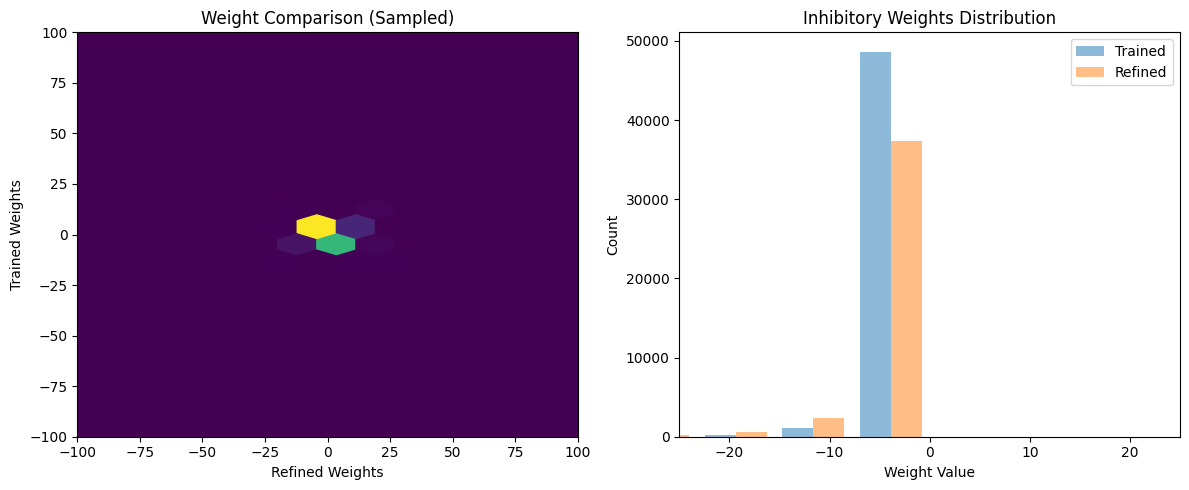

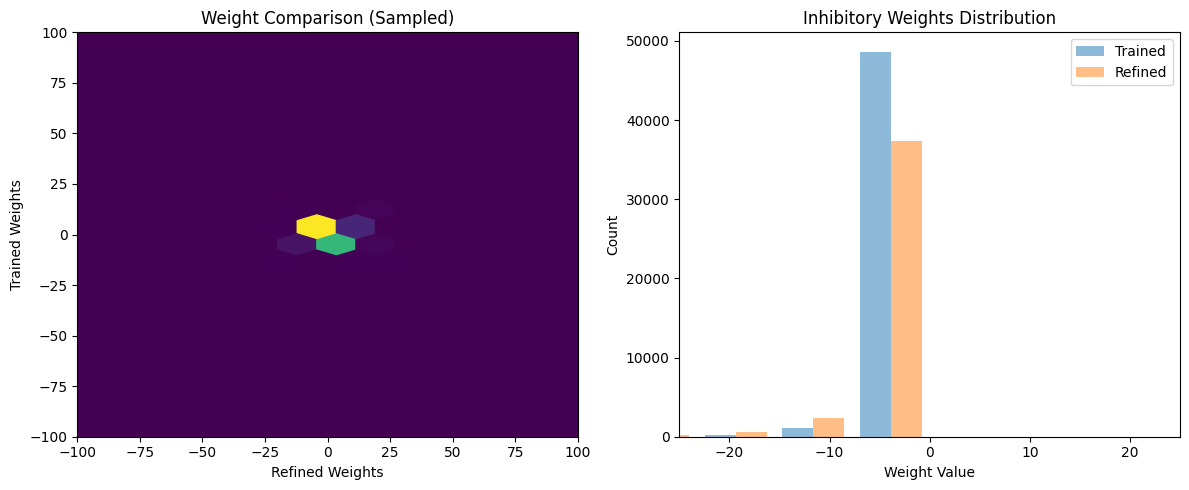

In [15]:
plt.close("all")
fast_plot_comparison(df)

# Correlation between strenghts

In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import pandas as pd
import config
from graph_models import FullGraphModel
from data_processing import DataProcessor


device_type = "cpu"
device = torch.device(device_type)
dtype = torch.float32
cmap = plt.cm.binary

batch_size = config.batch_size

In [2]:
data_processor = DataProcessor(config)
model = FullGraphModel(data_processor, config).to(device)
criterion = CrossEntropyLoss()

checkpoint = torch.load(
    "models/m_2025-02-01 07:43_eo3d2g2c.pth",
    map_location=device_type,
)
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)

/tmp/ipykernel_46391/1097545415.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [7]:
original_weights = model.connectome.edge_weight.detach().cpu().numpy()
trained_weights = original_weights * model.connectome.edge_weight_multiplier.detach().cpu().numpy()
df = pd.DataFrame({"trained": trained_weights.flatten(), "original": original_weights.flatten()})

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, ks_2samp
import seaborn as sns


def analyze_weight_changes(df):
    """
    Comprehensive analysis of weight changes between original and trained networks.

    Parameters:
    df: pandas DataFrame with columns 'original' and 'trained'

    Returns:
    dict containing analysis results
    """
    results = {}

    # 1. Basic Statistics
    results["basic_stats"] = {
        "mean_ratio": df["trained"].mean() / df["original"].mean(),
        "std_ratio": df["trained"].std() / df["original"].std(),
        "abs_mean_diff": np.mean(np.abs(df["trained"] - df["original"])),
        "relative_change": np.mean(
            np.abs(df["trained"] - df["original"]) / np.abs(df["original"])
        ),
    }

    # 2. Correlation Analysis
    pearson_corr, p_value = pearsonr(df["original"], df["trained"])
    spearman_corr, spearman_p = spearmanr(df["original"], df["trained"])
    results["correlations"] = {
        "pearson": pearson_corr,
        "pearson_p": p_value,
        "spearman": spearman_corr,
        "spearman_p": spearman_p,
    }

    # 3. Sign Changes Analysis
    sign_changes = np.sum(np.sign(df["original"]) != np.sign(df["trained"]))
    results["sign_analysis"] = {
        "total_sign_changes": sign_changes,
        "sign_change_ratio": sign_changes / len(df),
    }

    # 4. Distribution Similarity
    ks_stat, ks_p = ks_2samp(df["original"], df["trained"])
    results["distribution_similarity"] = {"ks_statistic": ks_stat, "ks_p_value": ks_p}

    # 5. Weight Magnitude Analysis
    results["magnitude_analysis"] = {
        "magnitude_increase_ratio": np.sum(
            np.abs(df["trained"]) > np.abs(df["original"])
        )
        / len(df),
        "mean_magnitude_change": np.mean(
            np.abs(df["trained"]) - np.abs(df["original"])
        ),
    }

    return results


def plot_weight_analysis(df):
    """
    Create visualizations for weight change analysis.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # 1. Scatter plot with identity line
    axes[0, 0].scatter(df["original"], df["trained"], alpha=0.5)
    max_val = max(df["original"].max(), df["trained"].max())
    min_val = min(df["original"].min(), df["trained"].min())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], "r--")
    axes[0, 0].set_xlabel("Original Weights")
    axes[0, 0].set_ylabel("Trained Weights")
    axes[0, 0].set_title("Original vs Trained Weights")

    # 2. Distribution comparison
    sns.kdeplot(data=df, x="original", label="Original", ax=axes[0, 1])
    sns.kdeplot(data=df, x="trained", label="Trained", ax=axes[0, 1])
    axes[0, 1].set_title("Weight Distribution Comparison")
    axes[0, 1].legend()

    # 3. Weight changes histogram
    changes = df["trained"] - df["original"]
    axes[1, 0].hist(changes, bins=50)
    axes[1, 0].set_xlabel("Weight Change (Trained - Original)")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].set_title("Distribution of Weight Changes")

    # 4. Relative changes
    rel_changes = (df["trained"] - df["original"]) / np.abs(df["original"])
    axes[1, 1].hist(rel_changes, bins=50)
    axes[1, 1].set_xlabel("Relative Weight Change")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].set_title("Distribution of Relative Weight Changes")

    plt.tight_layout()
    return fig


def interpret_results(results):
    """
    Provide interpretation of the analysis results.

    Parameters:
    results: dict containing analysis results from analyze_weight_changes

    Returns:
    str: Detailed interpretation of results
    """
    interpretation = []

    # Correlation interpretation
    corr = results["correlations"]["pearson"]
    if abs(corr) > 0.8:
        interpretation.append(
            f"Strong correlation ({corr:.3f}) between original and trained weights suggests fine-tuning rather than complete rewiring."
        )
    elif abs(corr) > 0.5:
        interpretation.append(
            f"Moderate correlation ({corr:.3f}) indicates significant preservation of original structure with substantial modifications."
        )
    else:
        interpretation.append(
            f"Weak correlation ({corr:.3f}) suggests major rewiring of the network."
        )

    # Sign changes interpretation
    sign_ratio = results["sign_analysis"]["sign_change_ratio"]
    interpretation.append(
        f"{sign_ratio:.1%} of connections changed sign, indicating {'substantial' if sign_ratio > 0.2 else 'minimal'} rewiring of connection types."
    )

    # Distribution similarity
    if results["distribution_similarity"]["ks_p_value"] < 0.05:
        interpretation.append(
            "The distributions of original and trained weights are significantly different, suggesting substantial modification of the weight structure."
        )
    else:
        interpretation.append(
            "The overall distribution of weights is preserved, indicating more subtle modifications."
        )

    # Magnitude analysis
    mag_increase = results["magnitude_analysis"]["magnitude_increase_ratio"]
    interpretation.append(
        f"{mag_increase:.1%} of weights increased in magnitude, suggesting {'strengthening' if mag_increase > 0.5 else 'weakening'} of existing connections."
    )

    return "\n".join(interpretation)


# Example usage:
# results = analyze_weight_changes(df)
# interpretation = interpret_results(results)
# fig = plot_weight_analysis(df)
# plt.show()

In [ ]:
results = analyze_weight_changes(df)
interpretation = interpret_results(results)


/tmp/ipykernel_46391/3723203943.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [11]:
print(interpretation)

Weak correlation (0.004) suggests major rewiring of the network.
50.0% of connections changed sign, indicating substantial rewiring of connection types.
The distributions of original and trained weights are significantly different, suggesting substantial modification of the weight structure.
0.1% of weights increased in magnitude, suggesting weakening of existing connections.


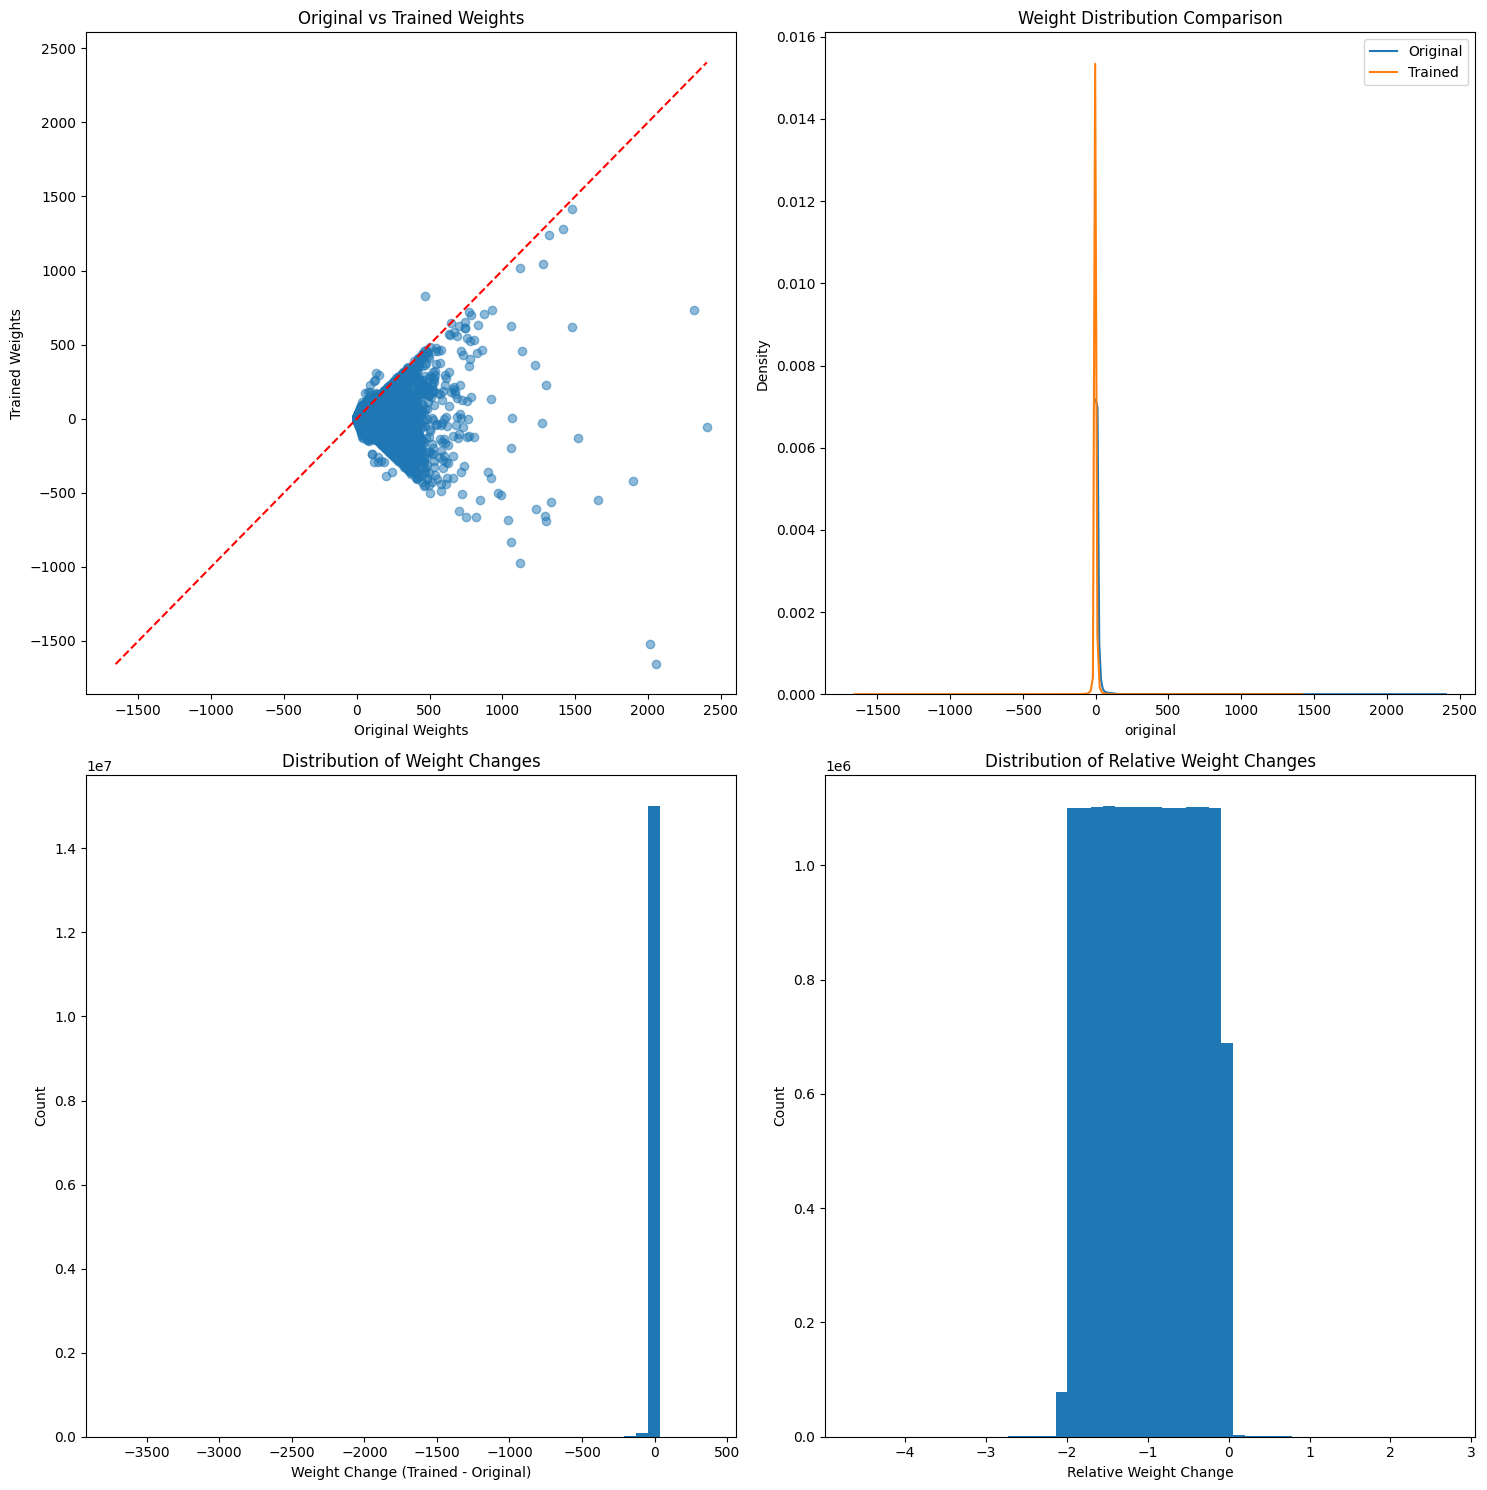

In [12]:
%matplotlib inline 

plt.close("all")
fig = plot_weight_analysis(df)
plt.show()

In [1]:
import os
import pandas as pd

all_neurons = pd.read_csv(
    os.path.join("new_data", "classification.csv"),
    usecols=["root_id", "cell_type", "side"],
    dtype={"root_id": "string"},
).fillna("Unknown")

In [2]:
all_neurons.cell_type.value_counts()

cell_type
Unknown    28165
R1-6        8452
Dm3         2545
T2a         1781
Tm3         1746
           ...  
CB3142         1
CB3814         1
CB1453         1
DNp72          1
CB1714         1
Name: count, Length: 5635, dtype: int64